# Using Recipe Ingredients to Categorize Cuisine

By Eka Renardi. October 20, 2015

## 1. Introduction

Kaggle posed a challenge for predicting the category of cuisine based on its recipe ingredients. This document outlines my approach for solving this Kaggle Competition, [What's Cooking](https://www.kaggle.com/c/whats-cooking). 

## 2. Dataset

*Yummly* graciously provided the dataset for this challenge. The dataset consists of train and test set. The train set listed the cuisines, and ingredients for the cuisine.  The test set data listed just the ingredients. A sample train data set is as follows:

```
{
    "id": 25693,
    "cuisine": "southern_us",
    "ingredients": [
      "plain flour",
      "ground pepper",
      "salt",
      "tomatoes",
      "ground black pepper",
      "thyme",
      "eggs",
      "green tomatoes",
      "yellow corn meal",
      "milk",
      "vegetable oil"
    ]
}
```

Attributes:

- "id" - unique identifier
- "cuisine" - category of a cuisine
- "ingredients" - ingredients used to make the cuisine


### 2.1 Data Import
Lets read it

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2, SelectPercentile, SelectKBest, f_classif
from sklearn.cross_validation import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import KernelPCA, TruncatedSVD
from sklearn.lda import LDA
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn import metrics
from scipy.stats import sem
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, roc_curve, auc
from sklearn.datasets import make_classification
import matplotlib.pylab as pyl
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

sns.set_style('whitegrid')

In [2]:
df = pd.read_json('../data/train.json')

## 3. Exploratory Statistics
In my attempt to understand the data, several exploratory statistics are constructed.

### 3.1. How many unique cuisines are there, and what are they?

('shape:', (39774, 3))
('unique cuisine count:', 20)


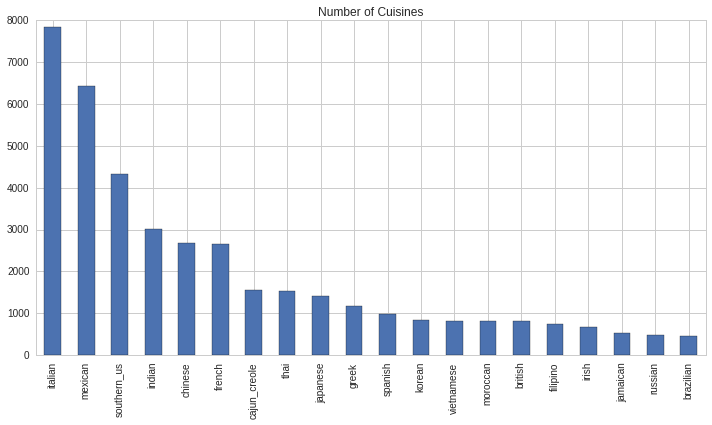

In [3]:
cuisines = df.cuisine.value_counts(sort=True)
cuisines.plot(kind="bar", figsize=(12,6), title="Number of Cuisines")
print("shape:", df.shape)
print("unique cuisine count:", len(df.cuisine.unique()))

### 3.2. What is the most often used ingredients by all cuisine? and what is the most often used ingredients for each cuisine?

In [4]:
# calculating the usage of each ingredient, and for each cuisine
cuisine_dict = defaultdict(Counter)
index_dict = defaultdict(Counter)
total_counter = Counter()
# iterate each row
for index, row in df.iterrows():
    # get the counters
    row_counter = index_dict[row.id] 
    local_counter = cuisine_dict[row.cuisine]
    # count the ingredients usage
    arr = row.ingredients
    for ingredient in row.ingredients:
        key = ingredient.lower()
        # increment each word count
        total_counter[key] += 1
        local_counter[key] += 1
        row_counter[key] += 1
    # update the counters
    cuisine_dict[row.cuisine] = local_counter
    index_dict[row.id] = row_counter
    

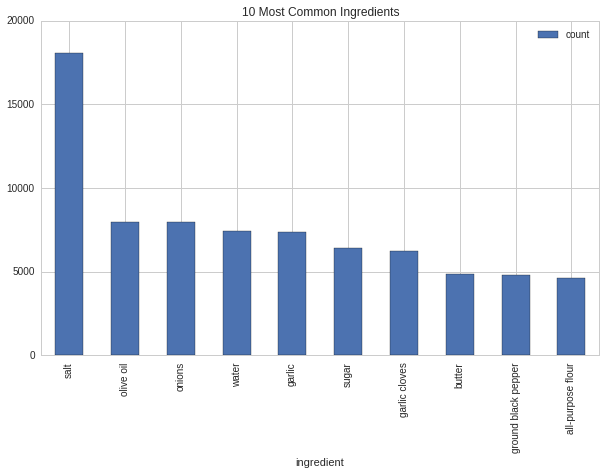

In [5]:
# plotting most common ingredients
most_common_ingredients = pd.DataFrame(total_counter.most_common(10), columns=["ingredient", "count"])
most_common_ingredients.plot(kind="bar", x="ingredient", figsize=(10,6), title="10 Most Common Ingredients")   

Let's draw a word cloud for top 100 ingredients.

/home/morita/anaconda/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


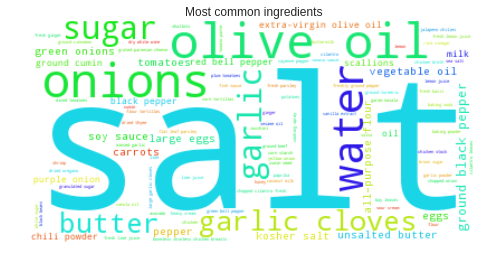

In [6]:
from wordcloud import WordCloud
wordcloudobj = WordCloud( background_color='white')
wordcloud = wordcloudobj.generate_from_frequencies(total_counter.most_common(100))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common ingredients")
plt.show()

Now let's look at the 100 most common ingredients used for each cuisine

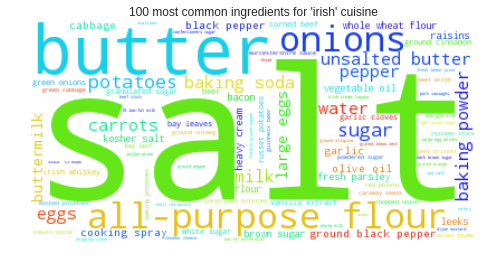

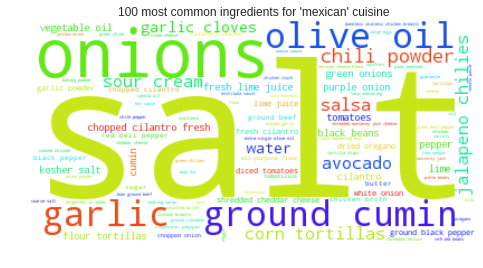

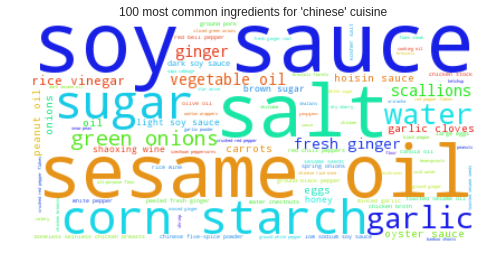

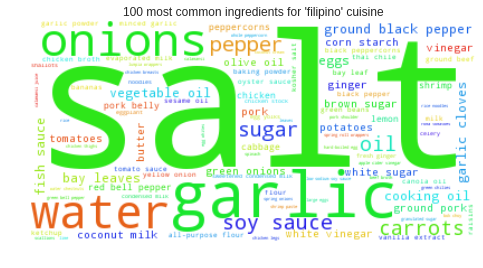

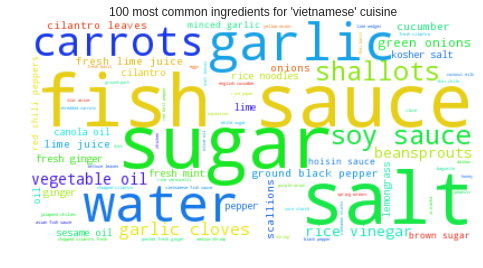

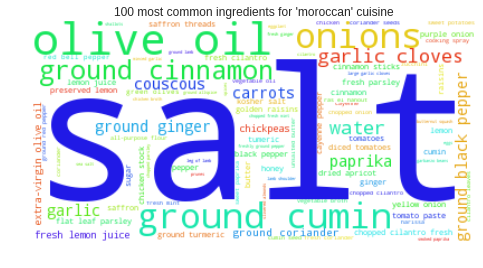

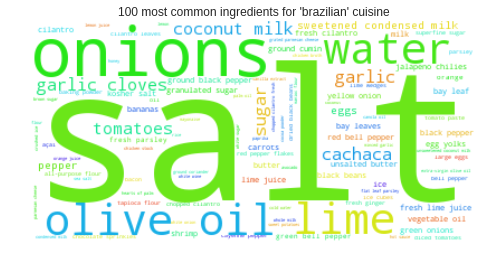

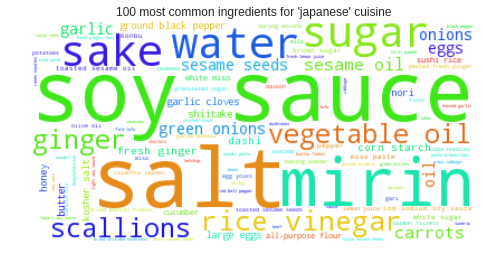

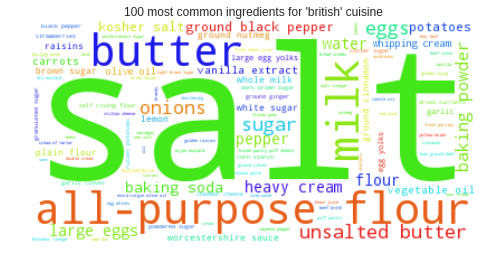

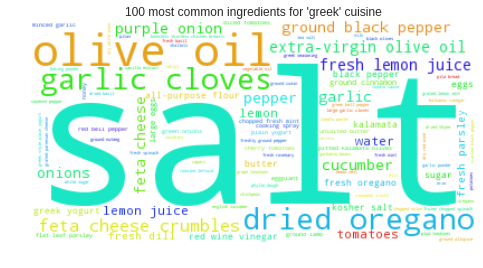

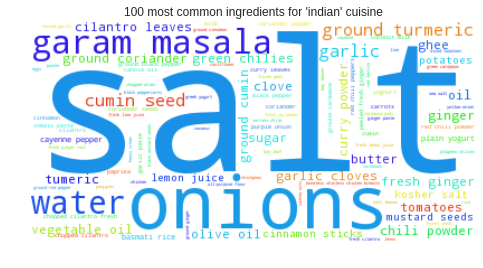

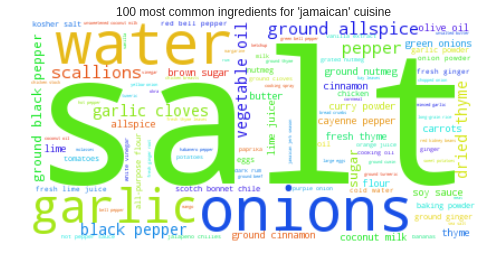

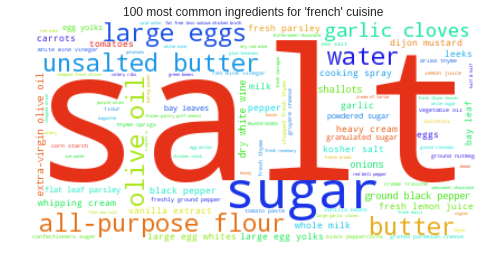

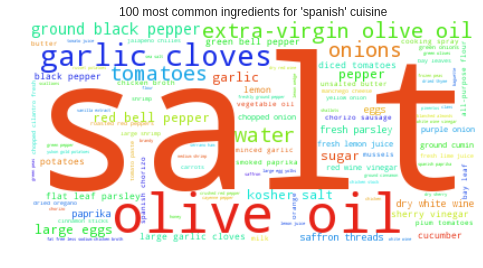

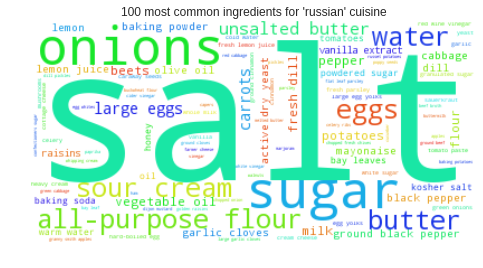

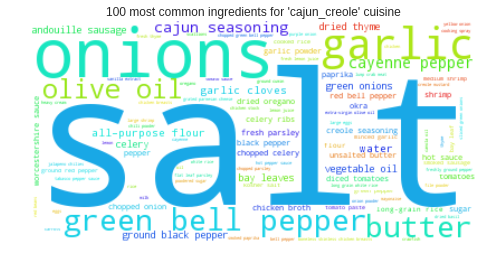

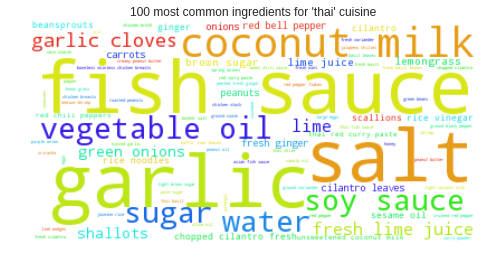

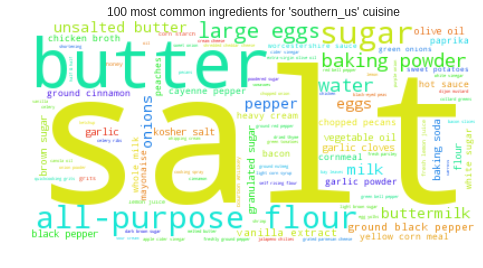

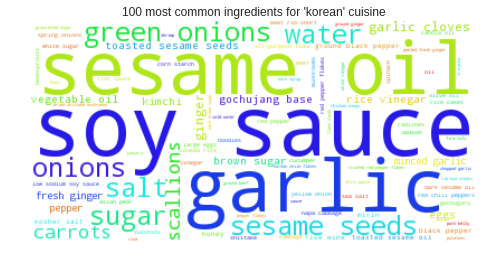

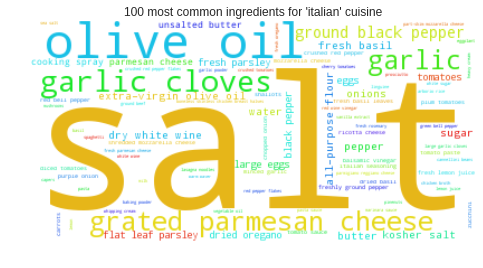

In [7]:
for key, value in cuisine_dict.iteritems():
    wc = wordcloudobj.generate_from_frequencies(value.most_common(100))
    plt.imshow(wc)
    plt.title("100 most common ingredients for '%s' cuisine" % key)
    plt.axis("off")
    plt.show()    

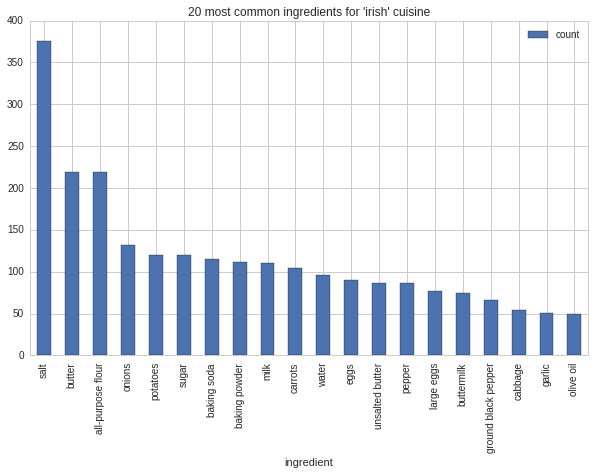

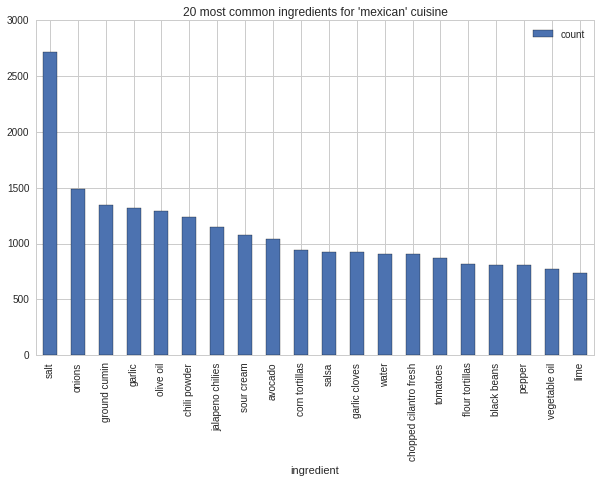

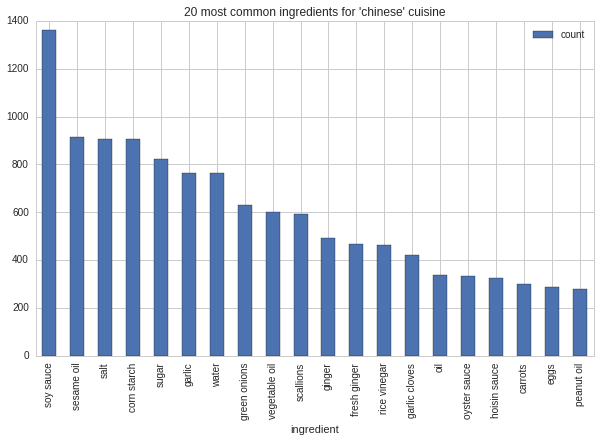

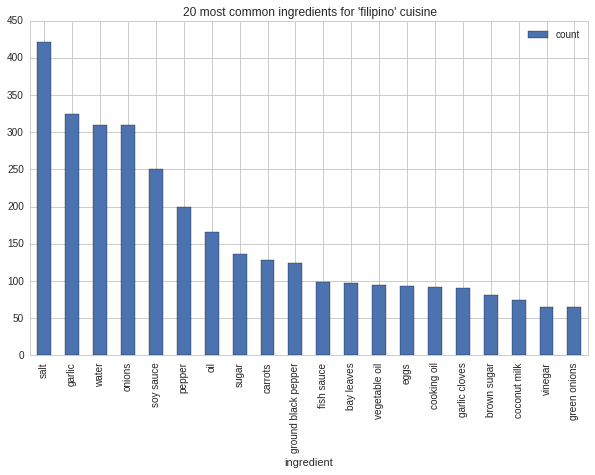

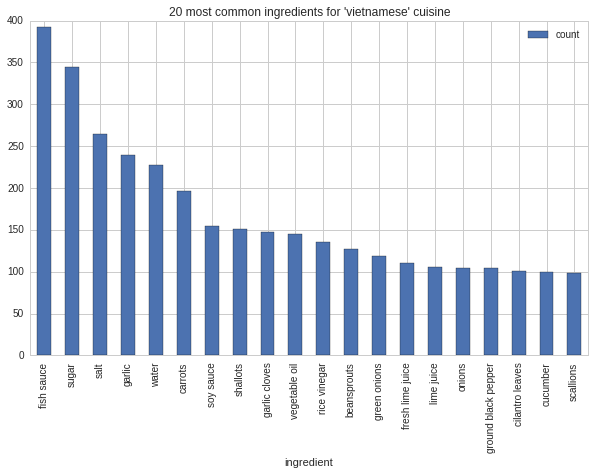

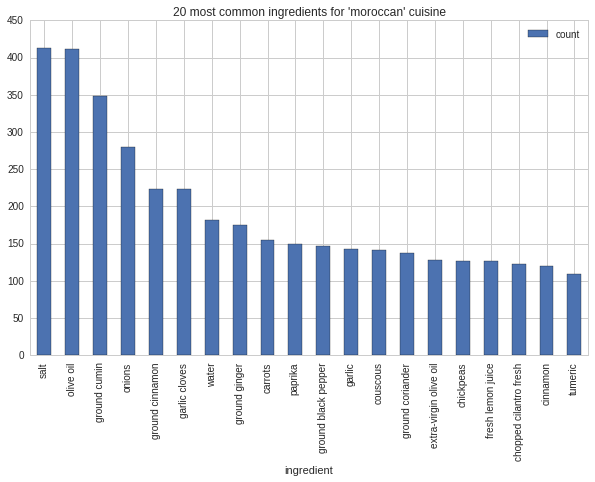

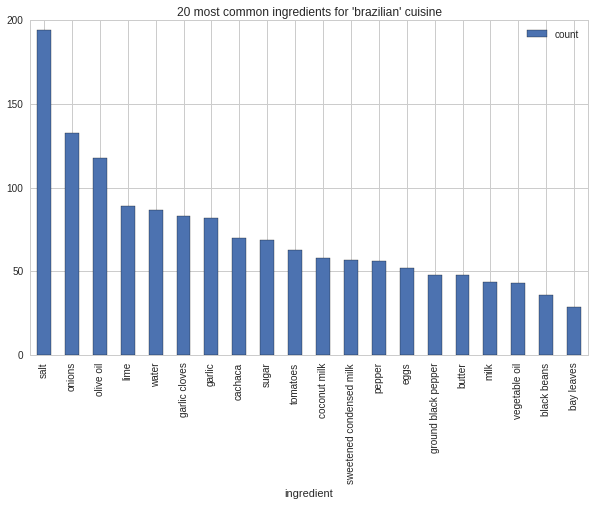

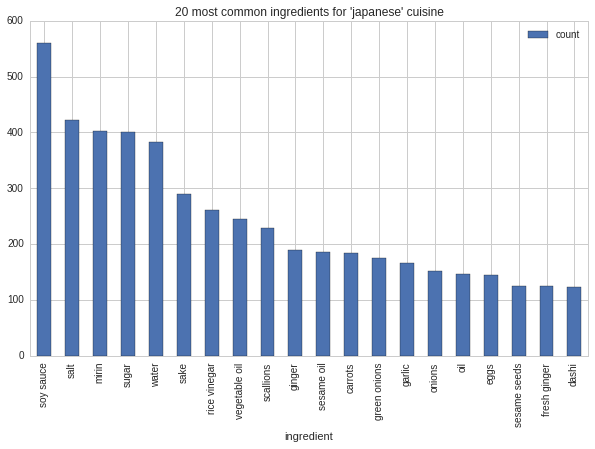

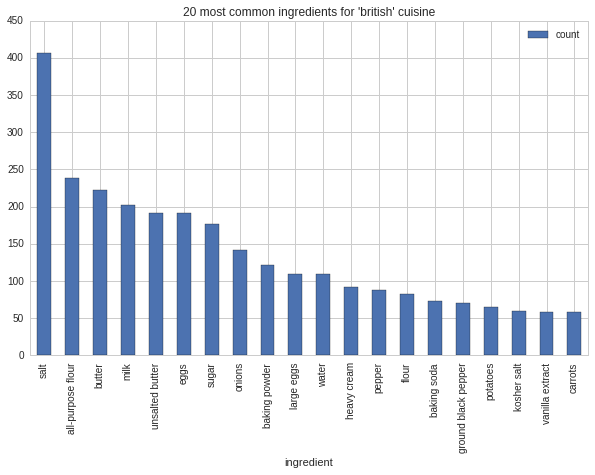

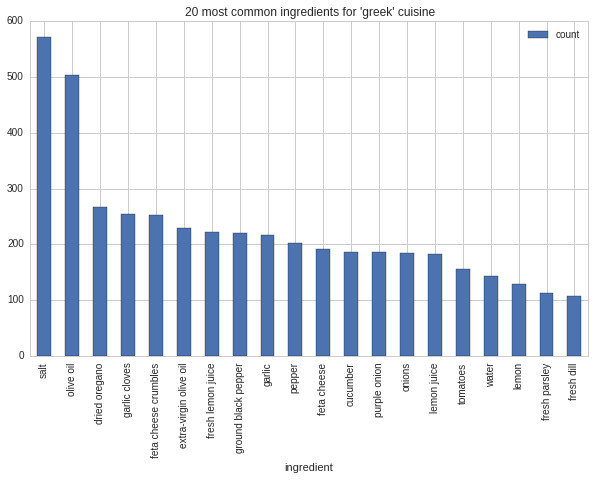

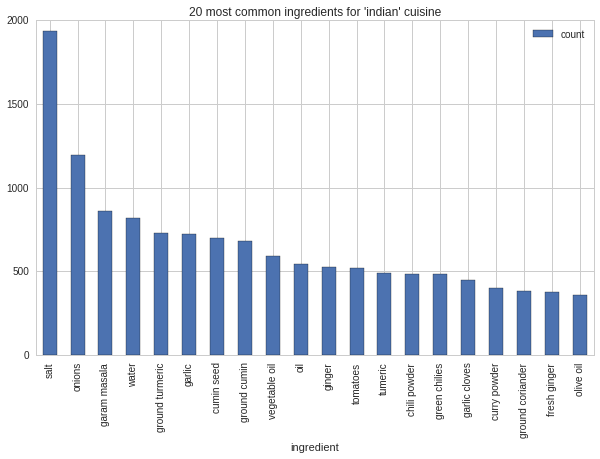

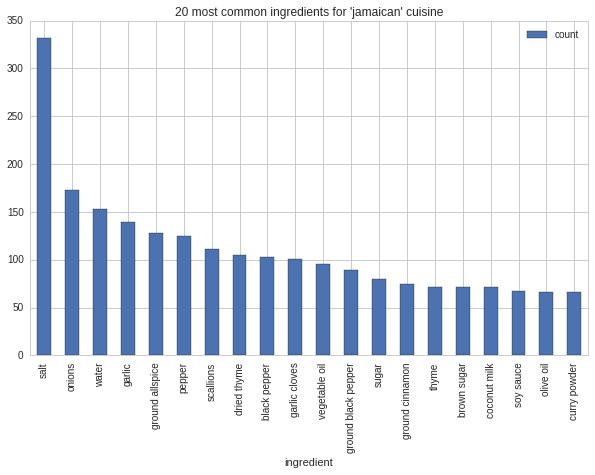

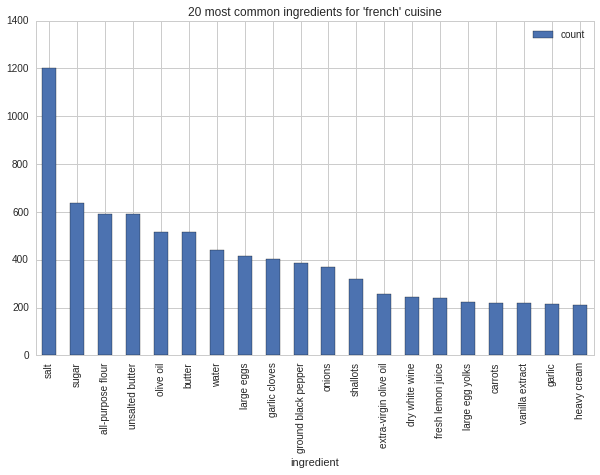

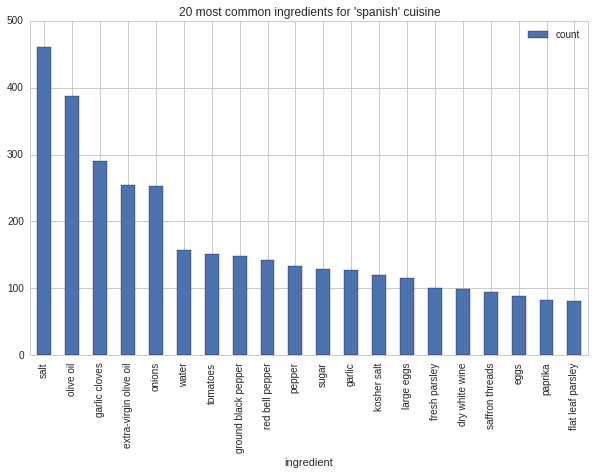

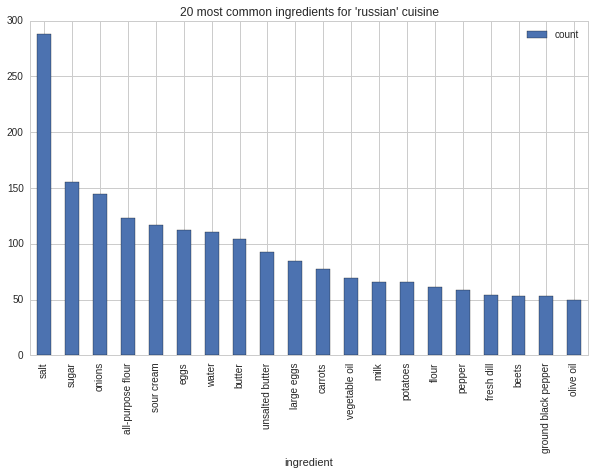

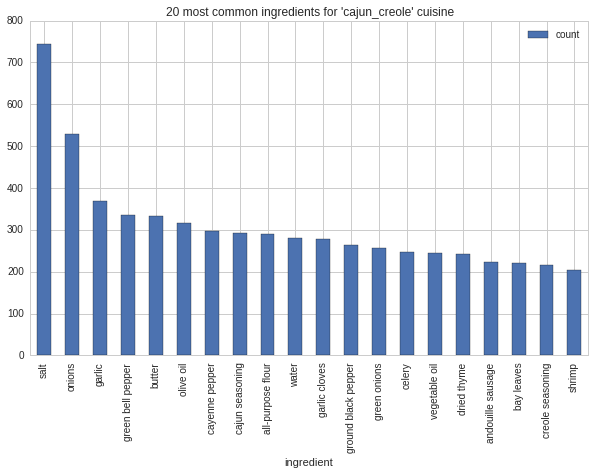

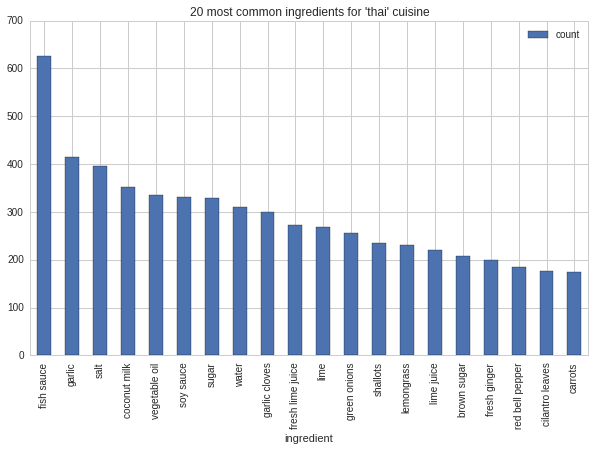

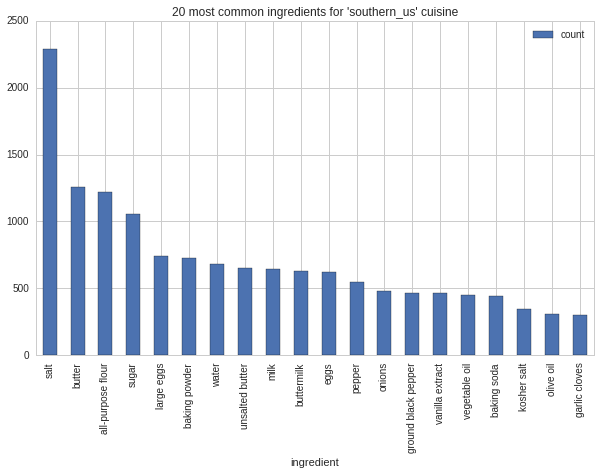

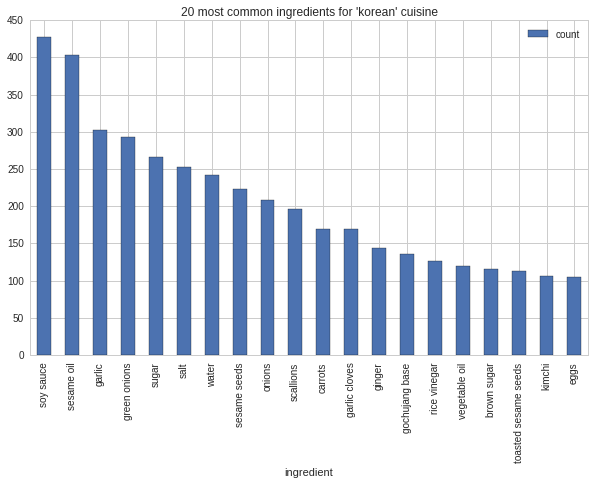

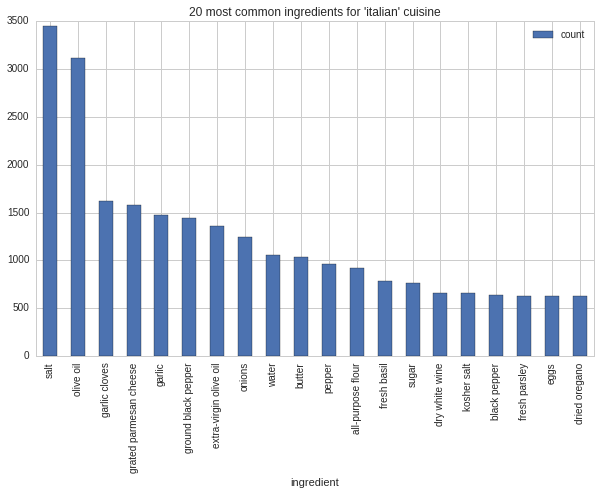

In [8]:
# bar char plot of top 20 most common ingredients
for key, value in cuisine_dict.iteritems():
    mc = pd.DataFrame(value.most_common(20), columns=["ingredient", "count"])
    mc.plot(kind="bar", x="ingredient", figsize=(10,6), title="20 Most Common Ingredients")   
    plt.title("20 most common ingredients for '%s' cuisine" % key)
    plt.show()   

### 3.3. What is the ngram range for each cuisine?

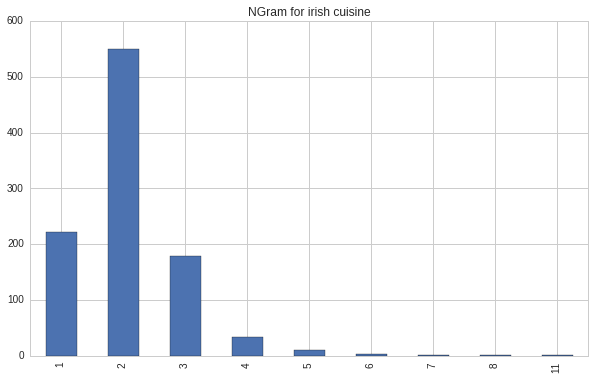

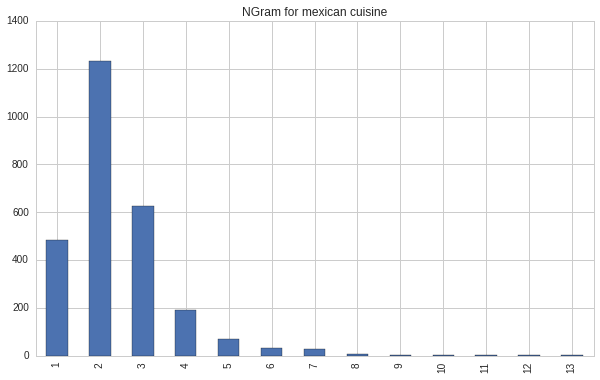

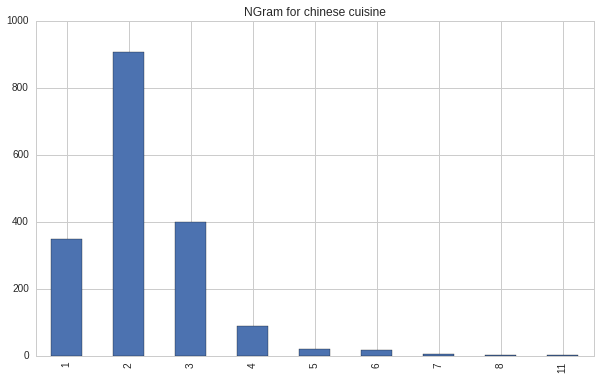

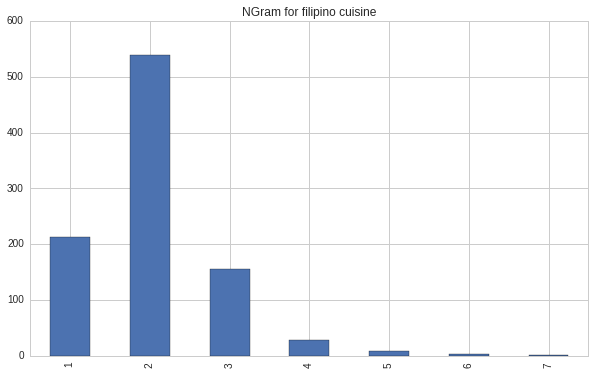

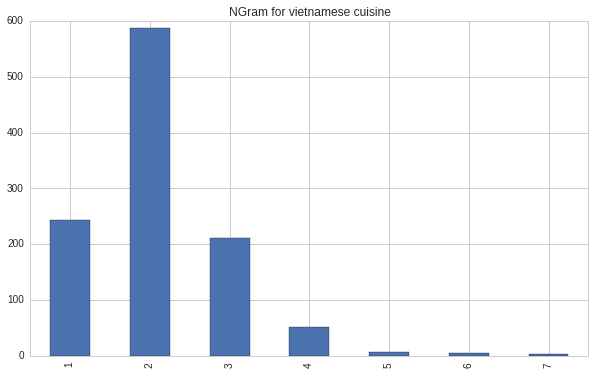

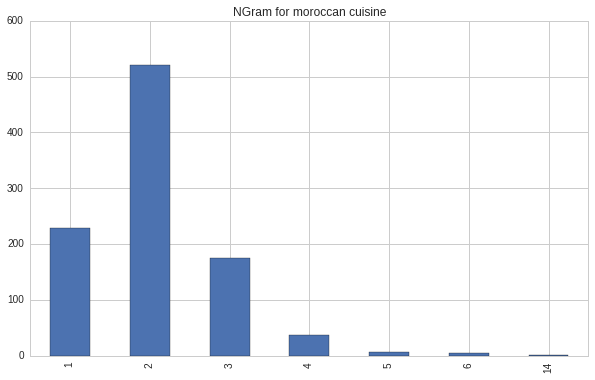

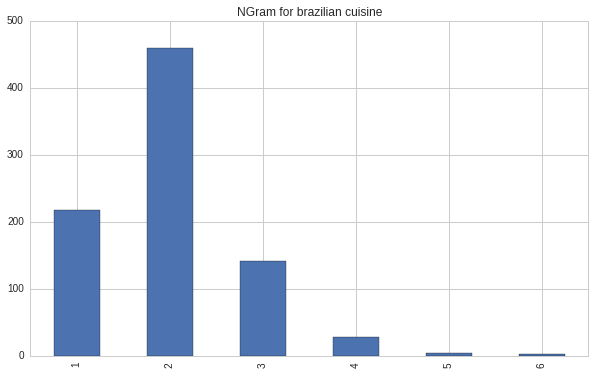

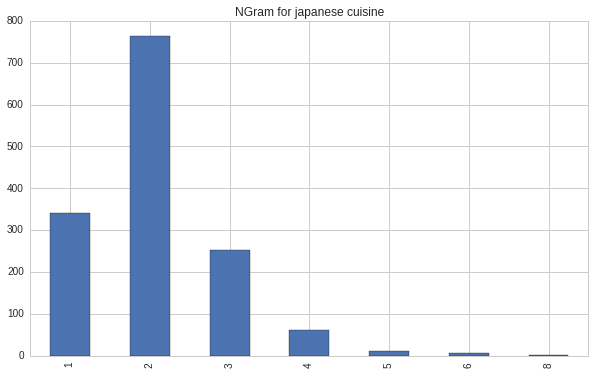

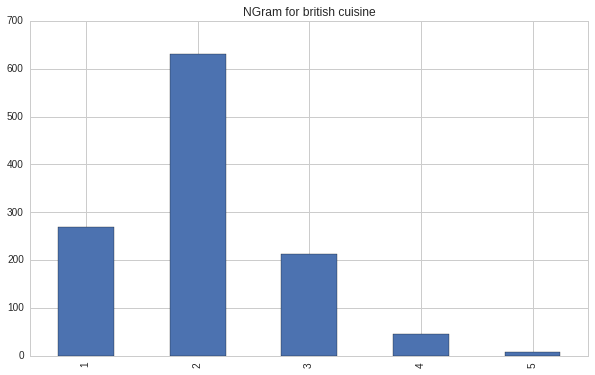

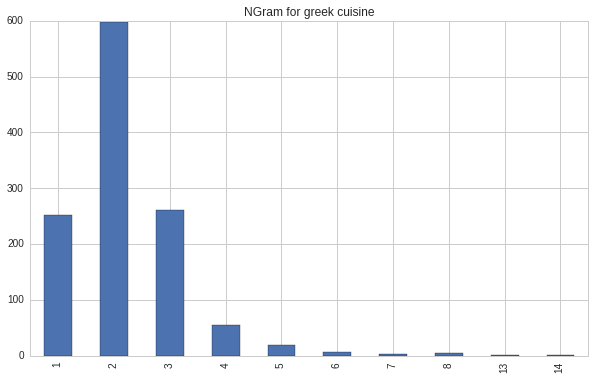

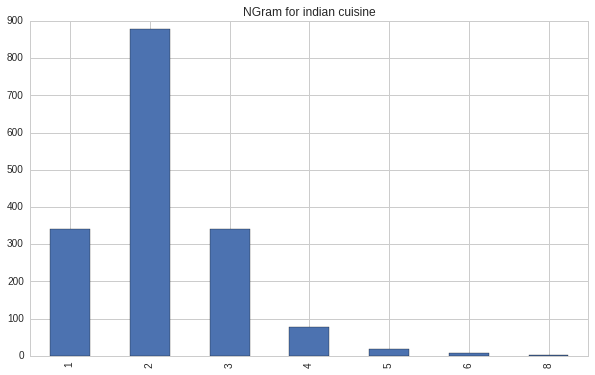

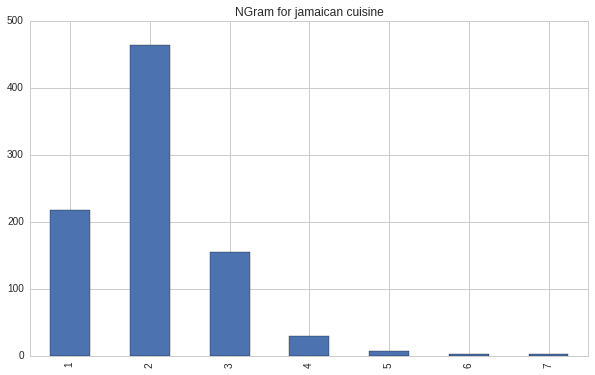

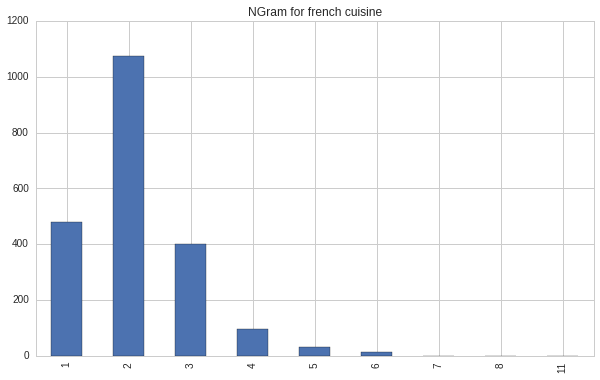

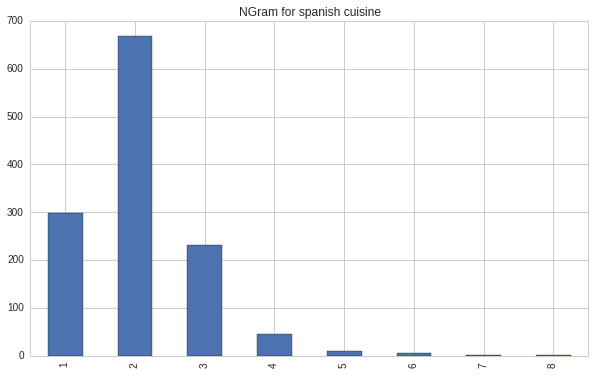

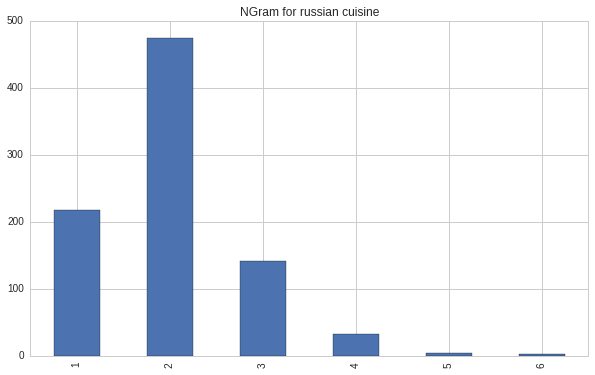

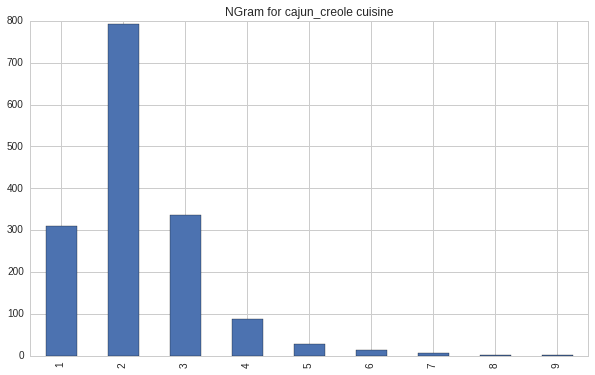

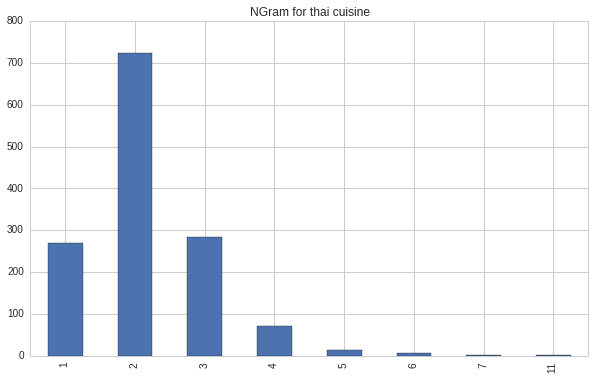

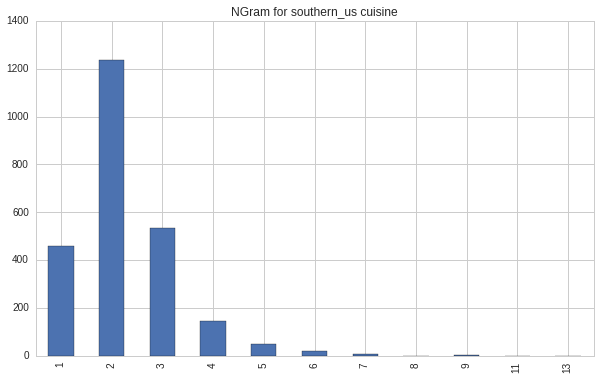

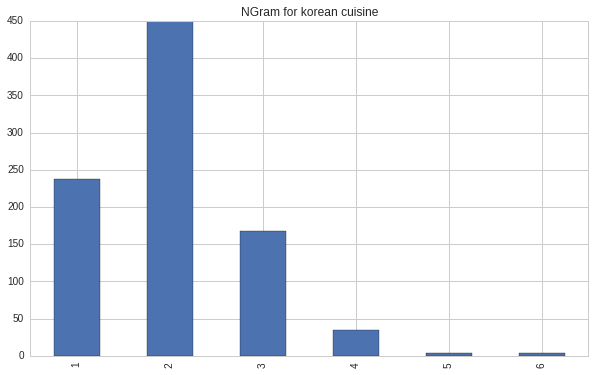

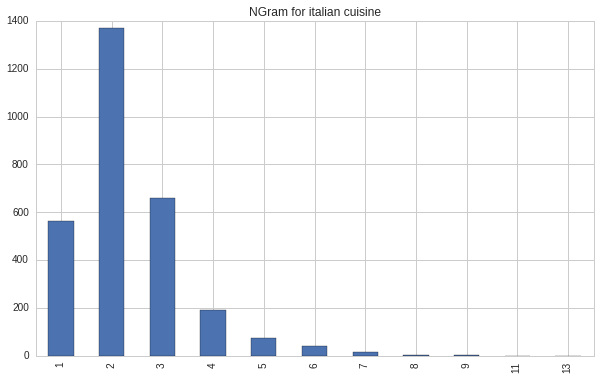

In [9]:
# ngram range for each cuisine
stemmer = PorterStemmer()
ngram_counters = {}
for key, value in cuisine_dict.iteritems():
    rng = [len(word_tokenize(stemmer.stem(wc))) for wc, val in value.iteritems()]  
    local_ngram_counter = Counter(rng)
    ngram_counters[key] = local_ngram_counter
    local_series = pd.Series(local_ngram_counter)
    local_series.plot(kind="bar", figsize=(10,6), title="NGram for %s cuisine" % key)  
    plt.show()



In [10]:
# vector of ngram for each cuisine
ngram_index = {}
for key, value in ngram_counters.iteritems():
    ngram_index[key] = dict(value)
df_ngram = pd.DataFrame.from_dict(ngram_index, orient='index')
df_ngram = df_ngram.fillna(0)
df_ngram

1     2    3    4   5   6   7   8   11  9   10  12  13  14
brazilian     217   459  142   28   4   3   0   0   0   0   0   0   0   0
british       269   630  213   46   7   0   0   0   0   0   0   0   0   0
cajun_creole  309   793  336   87  27  14   6   1   0   2   0   0   0   0
chinese       348   908  401   90  21  16   4   2   1   0   0   0   0   0
filipino      213   539  155   28   8   3   1   0   0   0   0   0   0   0
french        478  1074  402   97  33  13   1   1   1   0   0   0   0   0
greek         252   597  260   54  19   7   3   4   0   0   0   0   1   1
indian        341   878  340   78  19   7   0   1   0   0   0   0   0   0
irish         221   549  178   34  11   3   1   1   1   0   0   0   0   0
italian       564  1370  660  190  76  42  14   5   1   5   0   0   1   0
jamaican      217   464  155   29   7   3   2   0   0   0   0   0   0   0
japanese      342   765  252   62  11   6   0   1   0   0   0   0   0   0
korean        238   450  168   35   4   3   0   0   0   0   0   0   0   0
mexican       482  1234  626  192  70  34  27   7   2   3   2   1   1   0
moroccan      228   521  175   37   7   5   0   0   0   0   0   0   0   1
russian       218   474  142   32   4   2   0   0   0   0   0   0   0   0
southern_us   458  1237  536  145  51  19   8   1   1   2   0   0   1   0
spanish       299   668  232   46  10   5   2   1   0   0   0   0   0   0
thai          270   724  285   71  15   7   3   0   1   0   0   0   0   0
vietnamese    243   587  211   52   7   5   3   0   0   0   0   0   0   0

1     21.280900
2     51.157130
3     20.122056
4      4.913087
5      1.409127
6      0.675421
7      0.257140
8      0.085713
11     0.027428
9      0.041142
10     0.006857
12     0.003429
13     0.013714
14     0.006857
dtype: float64

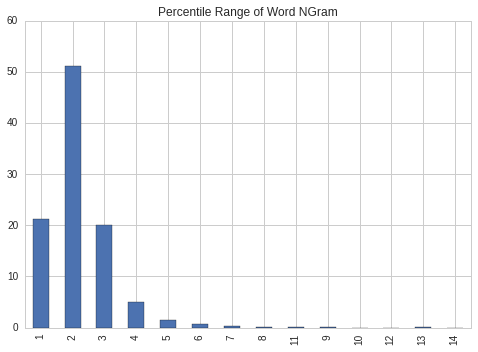

In [11]:
# getting the percentage of ngram for each cuisines
totalcount = df_ngram.sum().sum()
ngram_sum = df_ngram.sum().groupby(level=0).apply(lambda x: 100*x/float(totalcount))
ngram_sum.plot(kind="bar", title="Percentile Range of Word NGram")
ngram_sum

Most cuisines, about 91%, are 1 to 3 words in length

### 3.4 Are there groupings between ingredients and cuisines?

In [12]:
# get a vector of cuisines and ingredients
index1 = {}
for key, value in cuisine_dict.iteritems():
    index1[key] = dict(value)
df1 = pd.DataFrame.from_dict(index1, orient='index')
df1 = df1.fillna(0)
cuisine_labels = [key for key, value in df1.iterrows()]
ingredients_labels = list(df1.columns)

# calculating the table of probabilities for the cuisines
inst_count=df1.sum(axis='columns')
df1_prob= df1.div(inst_count,axis='rows')

In [13]:
mds = MDS(n_components=2,  random_state=1)
X = mds.fit_transform(df1_prob.astype(np.float64))
x1 = X[:,0]
y1 = X[:,1]

/home/morita/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


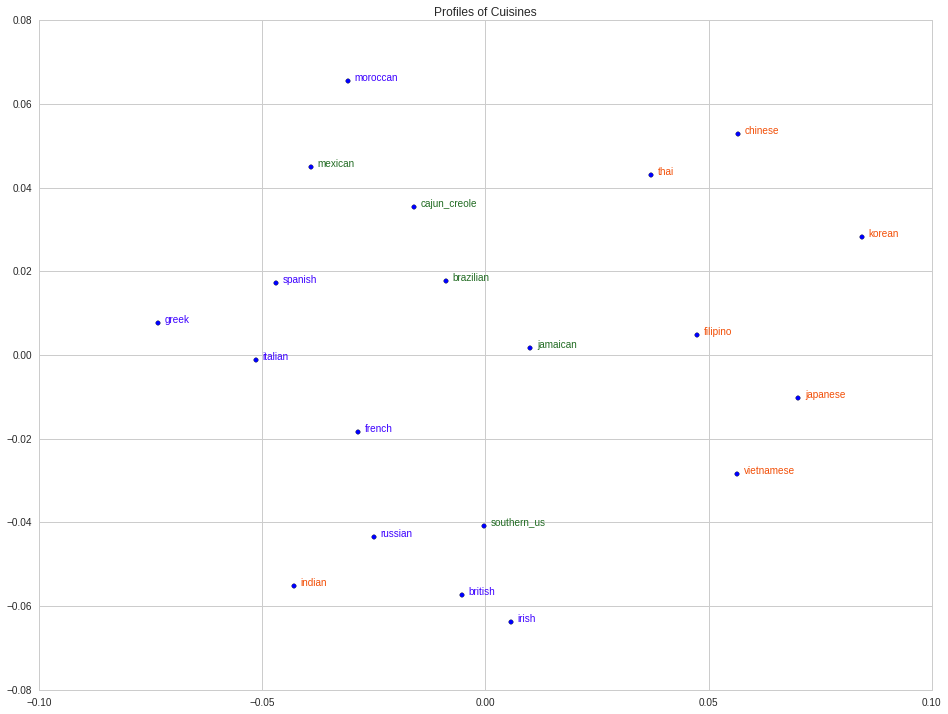

In [14]:
pyl.rcParams['figure.figsize'] = (16.0, 12.0)

fig, ax = plt.subplots()
ax=plt.scatter(x1,y1)
plt.title('Profiles of Cuisines')

colors = {
    'brazilian':    '#216b22',
    'british':      '#3c00ff',
    'cajun_creole': '#216b22',
    'chinese':      '#f24e06',
    'filipino':     '#f24e06',
    'french':       '#3c00ff',
    'greek':        '#3c00ff',
    'indian':       '#f24e06',
    'irish':        '#3c00ff',
    'italian':      '#3c00ff',
    'jamaican':     '#216b22',
    'japanese':     '#f24e06',
    'korean':       '#f24e06',
    'mexican':      '#216b22',
    'moroccan':     '#3c00ff',
    'russian':      '#3c00ff',
    'southern_us':  '#216b22',
    'spanish':      '#3c00ff',
    'thai':         '#f24e06',
    'vietnamese':   '#f24e06'
}

for i, name in enumerate(cuisine_labels):
    plt.annotate(name, (x1[i], y1[i]), color=colors[name], xytext=(7,1), textcoords='offset points')
    
plt.show()

It appears that there is some sort of grouping with ingredients and cuisines. 

# 4. Model Building

The response variable for the model is the **cuisine**.  It is a categorical variable.

The predictor variable is the **ingredients**. It is a list of text. 


![Fig 1. Model Building Approach](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/approach.png)

##### Data Cleaning

Given that this is a text classification problem. The following data cleaning procedure are performed. 

1. Word replacement. 
2. Stop words. 
3. Stemming words.

##### Feature Engineering

Once the data is cleaned, the following feature engineering are then performed.

1. TFIDF features: analyzer, ngram_range, max_features
2. Ingredient Length
3. Regional Encoding (work in progres...)


##### Modeling

The model is subsequently developed following the progression below.  For each model, the approach that I use for selection is one with the highest accuracy score. Score is cross validated across 5 folds. 

1. Logistic Regression.
2. Linear SVC

##### Model Prediction

The final model is then tested against test data, and prediction is produced against test.json data. 

![Fig 2. Train Test Split](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/train_test_split.png)



## 4.1. Modeling Data Preparation

In [15]:
# read the data again
df = pd.read_json('../data/train.json')

In [16]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

### 4.1.1. Data Cleaning

The following are performed on the ingredients text:

1. Use of thesauri to clean and replace ingredient.
2. Removing stop words.
3. Stemming the words. 


In [17]:
# replacement data. Philadelphia Cream Cheese -> cream cheese
thesauri = {}
with open("../code/thesauri.txt", "r") as f:
    for line in f:
        entry = line.strip().split(",")
        key = entry[0]
        value = entry[1]
        thesauri[key] = value
f.close()

In [18]:
# custom stop words
stopwords = []
with open("../code/stopwords.txt", "r") as f:
    for line in f:
        stopwords.append(line.strip())
f.close()

In [19]:
# clean ingredients
def clean_ingredients(ingredients):
    stemmer = PorterStemmer()
    new_ingredients = []
    for one in ingredients:
        # if match thesauri, then use its simpler form
        newone = one 
        if one in thesauri:
            newone = thesauri[one]
        # if is not a stop word, then append
        new_ingredients.append(
            " ".join([stemmer.stem(t) for t in word_tokenize(newone) if not t in stopwords])
        )
    return new_ingredients

class Tokenizer(object):
    def __call__(self, doc):
        return doc.split(",")

In [20]:
# now do it for all observations
df['ingredients_all'] = df.ingredients.apply(lambda x: ",".join(clean_ingredients(x)))

In [30]:
# no comma
df['ingredients_string'] = df.ingredients_all.apply(lambda x: x.replace(',', ' '))
# no stemming, replacement, comma, etc, just plain string
df['ingredients_clean'] = df.ingredients.apply(lambda x: " ".join(x))

Setting the response variable.

In [77]:
print df['ingredients_all'][:5]
print df['ingredients_string'][:5]
print df['ingredients_clean'][:5]

0    romain lettuc,black oliv,grape tomato,garlic,p...
1    plain flour,ground pepper,salt,tomato,ground b...
2    egg,pepper,salt,mayonais,cook oil,green chili,...
3                           water,veget oil,wheat,salt
4    black pepper,shallot,cornflour,cayenn pepper,o...
Name: ingredients_all, dtype: object
0    romain lettuc black oliv grape tomato garlic p...
1    plain flour ground pepper salt tomato ground b...
2    egg pepper salt mayonais cook oil green chili ...
3                           water veget oil wheat salt
4    black pepper shallot cornflour cayenn pepper o...
Name: ingredients_string, dtype: object
0    romaine lettuce black olives grape tomatoes ga...
1    plain flour ground pepper salt tomatoes ground...
2    eggs pepper salt mayonaise cooking oil green c...
3                       water vegetable oil wheat salt
4    black pepper shallots cornflour cayenne pepper...
Name: ingredients_clean, dtype: object


In [34]:
# mapping categorical response var
cuisine_mapping = {label:idx for idx,label in enumerate(np.unique(df['cuisine']))}
cuisine_mapping

{u'brazilian': 0,
 u'british': 1,
 u'cajun_creole': 2,
 u'chinese': 3,
 u'filipino': 4,
 u'french': 5,
 u'greek': 6,
 u'indian': 7,
 u'irish': 8,
 u'italian': 9,
 u'jamaican': 10,
 u'japanese': 11,
 u'korean': 12,
 u'mexican': 13,
 u'moroccan': 14,
 u'russian': 15,
 u'southern_us': 16,
 u'spanish': 17,
 u'thai': 18,
 u'vietnamese': 19}

In [35]:
# mapping categorical response var
df['cuisine_idx'] = df.cuisine.map(cuisine_mapping)
# set the response variable
y = df['cuisine_idx']

For each model the following function is executed.  It evaluates the accuracy score through cross validation (5 folds).

In [36]:
# cross validate each model
def cross_val_models(models, X, y, K):
    predLst = []
    for model in models:
        score, sem_score = cross_val_validation(model[1], X, y, K)
        predLst.append({'name': model[0],
                        'score': score,
                        'sem' : sem_score})
        print "Cross_val %s...%0.3f" % (model[0], score)
    return predLst

# get the mean score, and standard error mean
def cross_val_validation(clf, X, y, K):
    # create a k-fold cross validation iterator of K folds
    cv = StratifiedKFold(y=y, n_folds=K, shuffle=True, random_state=1)
    #cv = KFold(len(y), K, shuffle=True, random_state=0)
    # get the mean score, and standard error mean
    scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")
    return np.mean(scores),  sem(scores)

# grid search helper 
def grid_search_models(name, clf, param_grid, X, y, K):
    grid = GridSearchCV(clf, param_grid, cv=K, scoring='accuracy')
    grid.fit(X, y)
    
    print "Grid_search %s...%0.3f" % (name, grid.best_score_)
    return dict({'name': name, 
                 'score': grid.best_score_,
                 'best_params' : grid.best_estimator_,
                 'scores': grid.grid_scores_
                })

def cross_val_model(clf, X, y, K):
    score, sem = cross_val_validation(clf, X, y, K)
    print "Cross_val ...%0.3f" % (score)
    return dict({'score': score, 
                 'sem' : sem
                })
    
# grid mean score plot helper
def plot_grid_mean_scores(rng, result):
    grid_mean_scores = [result.mean_validation_score for result in result['scores']]
    plt.plot(rng, grid_mean_scores)
    plt.xlabel('Range Value')
    plt.ylabel('Cross-Validated Accuracy')
    
# get grid scores
def get_grid_scores_pd(result):
    temp = pd.DataFrame.from_dict(result['scores'])
    temp.columns = ['name', 'mean score', 'scores']
    return temp

## 4.2. Logistic Regression Model

For this model, I started out with various base models, choosing one with the best score. And proceeded with feature engineering that hopefully will result in an optimum score. 

### 4.2.1. Base models

Let's start by evaluating base models. 

In [37]:
# base models
models = [
    ('nb',
        Pipeline([('vect', CountVectorizer(strip_accents='unicode')),
                  ('clf', MultinomialNB())
                 ])
    ),
    ('logistic',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', tokenizer=Tokenizer())),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
X = df['ingredients_all']
predLst = cross_val_models(models, X, y, 5)
predDf = pd.DataFrame.from_dict(predLst)
predDf

Cross_val nb...0.723
Cross_val logistic...0.653


name     score       sem
0        nb  0.723085  0.002444
1  logistic  0.652690  0.004202

Looks like LogisticRegression with TFIDF has the highest score, **0.723**. This is with data cleaning, and unique ingredients are separated by comma.  

In [54]:
# testing with ingredients that have not been cleaned
model = Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', LogisticRegression(C=1e9))
         ])
X = df['ingredients_clean']
cross_val_model(model, X, y, 5)

Cross_val ...0.734


{'score': 0.73437424545259467, 'sem': 0.0028694880161077531}

With no data cleaning, the score has increased to **0.734**

In [38]:
# testing with cleaned ingredients without ','
model = Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', LogisticRegression(C=1e9))
         ])
X = df['ingredients_string']
cross_val_model(model, X, y, 5)

Cross_val ...0.744


{'score': 0.74362688847944425, 'sem': 0.0037556813501953517}

With data cleaning, but no comma, the score improved further to **0.743**

### 4.2.2. TFIDF features 

Attempting to improve the model by tuning the following parameters:

1. ngram_range, analyzer. This is for looking at word combination (unigram, bigram, etc) on either 'word' or 'char'
2. max_features. 

###### 4.2.2.1. NGram_Range, analyzer

Looking at exploratory analysis. Word nrange of 1-3 accounts for 91% of the cuisines.  And below, char nrange of 4-7 accounts for more 90% of the cuisines. Let's try that mix now. 

In [108]:
X = df['ingredients_all']
counter = Counter()
for _, row in X.iteritems():
    for item in row.split(','):
        n = len(item.split(' '))
        counter[n] += 1
word_count = dict(counter)
word_count


{1: 140318,
 2: 216000,
 3: 61950,
 4: 8451,
 5: 1876,
 6: 203,
 7: 48,
 8: 26,
 9: 7,
 10: 2,
 11: 18,
 13: 4}

percent
1   32.715556
2   50.361037
3   14.443825
4    1.970376
5    0.437395
6    0.047330
7    0.011191
8    0.006062
9    0.001632
10   0.000466
11   0.004197
13   0.000933

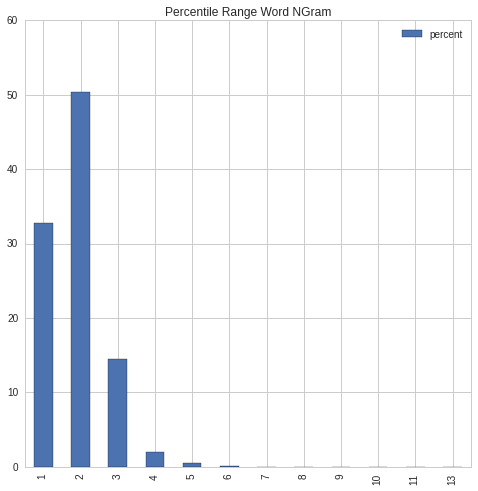

In [109]:
# get the word ngram dataframe
df_word_ngram = pd.DataFrame.from_dict(word_count, orient='index')
df_word_ngram.columns = ['percent']
# calculate percentages
totalcount = df_word_ngram.sum()
ngram_word_sum = df_word_ngram.groupby(level=0).apply(lambda x: 100*x/float(totalcount))
ngram_word_sum.plot(kind="bar", title="Percentile Range Word NGram")
ngram_word_sum

In [110]:
# the word ngram range
word_ngram_range = [(1,3), (1, 5)]
# create the model
model = Pipeline([('tfidf', TfidfVectorizer(strip_accents='unicode', analyzer='word')),
                  ('clf', LogisticRegression(C=1e9))
         ])
param_grid = {
    'tfidf__ngram_range': word_ngram_range,
}
# cross validate using grid search
X = df['ingredients_string']
word_ngram_results = grid_search_models('word_ngram', model, param_grid, X, y, 5)
word_ngram_results

Grid_search word_ngram...0.783


{'best_params': Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True...class='ovr', penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0))]),
 'name': 'word_ngram',
 'score': 0.78335093277015133,
 'scores': [mean: 0.78335, std: 0.00359, params: {'tfidf__ngram_range': (1, 3)},
  mean: 0.78071, std: 0.00509, params: {'tfidf__ngram_range': (1, 5)}]}

In [111]:
wpd = get_grid_scores_pd(word_ngram_results)
wpd

name  mean score  \
0  {u'tfidf__ngram_range': (1, 3)}    0.783351   
1  {u'tfidf__ngram_range': (1, 5)}    0.780711   

                                              scores  
0  [0.782089927154, 0.787132445338, 0.78192559074...  
1  [0.779201205727, 0.787760743906, 0.77790346908...

Looks like word ngram increases our score to **0.783**

In [113]:
# get the char ngram 
X = df['ingredients_all']
counter = Counter()
for _, row in X.iteritems():
    for item in row.split(','):
        for one in item.strip().split(' '):
            n = len(one)
            counter[n] += 1
char_count = dict(counter)
char_count

{0: 10,
 1: 1286,
 2: 671,
 3: 73318,
 4: 186217,
 5: 237416,
 6: 172971,
 7: 65014,
 8: 40978,
 9: 6767,
 10: 13066,
 11: 738,
 12: 2855,
 13: 751,
 14: 35,
 15: 36,
 18: 3,
 19: 65}

percent
0    0.001247
1    0.160310
2    0.083645
3    9.139650
4   23.213375
5   29.595723
6   21.562160
7    8.104493
8    5.108222
9    0.843558
10   1.628777
11   0.091997
12   0.355898
13   0.093618
14   0.004363
15   0.004488
18   0.000374
19   0.008103

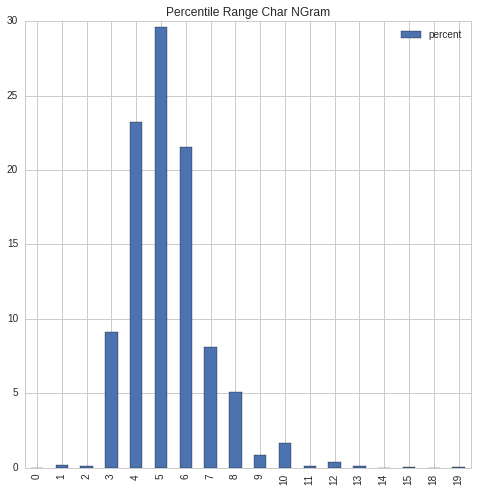

In [114]:
# get the char ngram dataframe
df_char_ngram = pd.DataFrame.from_dict(char_count, orient='index')
df_char_ngram.columns = ['percent']
# calculate percentages
totalcount = df_char_ngram.sum()
ngram_char_sum = df_char_ngram.groupby(level=0).apply(lambda x: 100*x/float(totalcount))
ngram_char_sum.plot(kind="bar", title="Percentile Range Char NGram")
ngram_char_sum

In [115]:
# the char ngram range
char_ngram_range = [(3,10), (3,7), (4,6)]
# create the model
model = Pipeline([('tfidf', TfidfVectorizer(strip_accents='unicode', analyzer='char')),
                  ('clf', LogisticRegression(C=1e9))
         ])
param_grid = {
    'tfidf__ngram_range': char_ngram_range,
}
# cross validate using grid search
X = df['ingredients_string']
char_ngram_results = grid_search_models('char_ngram', model, param_grid, X, y, 5)
char_ngram_results

Grid_search char_ngram...0.772


{'best_params': Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(3, 10), norm=u'l2', preprocessor=None,
         smooth...class='ovr', penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0))]),
 'name': 'char_ngram',
 'score': 0.77178558857545132,
 'scores': [mean: 0.77179, std: 0.00333, params: {'tfidf__ngram_range': (3, 10)},
  mean: 0.76268, std: 0.00492, params: {'tfidf__ngram_range': (3, 7)},
  mean: 0.75680, std: 0.00564, params: {'tfidf__ngram_range': (4, 6)}]}

In [116]:
cpd = get_grid_scores_pd(char_ngram_results)
cpd

name  mean score  \
0  {u'tfidf__ngram_range': (3, 10)}    0.771786   
1   {u'tfidf__ngram_range': (3, 7)}    0.762684   
2   {u'tfidf__ngram_range': (4, 6)}    0.756801   

                                              scores  
0  [0.768023109771, 0.776325709977, 0.77036199095...  
1  [0.755463451394, 0.769163106308, 0.76319758672...  
2  [0.747802059784, 0.763885398341, 0.75729009552...

Looks like char ngram does not improve the score.

###### 4.2.2.2. Max_features

Lets look at the max number of features per cuisine. Let's start with te max_features value as the minimum number of ingredients. 

In [76]:
# total number of ingredients per cuisine
total_ingredients_dict = {}
for key, value in cuisine_dict.iteritems():
    total_ingredients_dict[key] = len(value)
# tabulate it
df_total_ingredients = pd.DataFrame.from_dict(total_ingredients_dict, orient='index')
df_total_ingredients = df_total_ingredients.fillna(0)
print df_total_ingredients    
print()
print df_total_ingredients.describe()


                 0
irish          999
mexican       2681
chinese       1791
filipino       947
vietnamese    1108
spanish       1263
japanese      1439
moroccan       974
french        2100
greek         1198
indian        1664
jamaican       877
british       1165
brazilian      853
russian        872
cajun_creole  1575
thai          1376
southern_us   2459
korean         898
italian       2928
()
                0
count    20.00000
mean   1458.35000
std     633.51586
min     853.00000
25%     967.25000
50%    1230.50000
75%    1695.75000
max    2928.00000


In [ ]:
#predDf = predDf.ix[1:12]
#predDf.drop(predDf.index[14], inplace=True)

In [117]:
# testing with min features
model = Pipeline([('tfidf', TfidfVectorizer(strip_accents='unicode', 
                                            analyzer='word',
                                            ngram_range=(1,3),
                                            max_features=853
                                           )),
                  ('clf', LogisticRegression(C=1e9))
         ])
X = df['ingredients_string']
maxf_results = grid_search_models('max_features', model, param_grid, X, y, 5)
maxf_results

Grid_search max_features...0.471


{'best_params': Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=853, min_df=1,
         ngram_range=(3, 10), norm=u'l2', preprocessor=None,
         smooth_...class='ovr', penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0))]),
 'name': 'max_features',
 'score': 0.47101121335545831,
 'scores': [mean: 0.47101, std: 0.00297, params: {'tfidf__ngram_range': (3, 10)},
  mean: 0.47091, std: 0.00297, params: {'tfidf__ngram_range': (3, 7)},
  mean: 0.34952, std: 0.00459, params: {'tfidf__ngram_range': (4, 6)}]}

In [118]:
mpd = get_grid_scores_pd(maxf_results)
mpd

name  mean score  \
0  {u'tfidf__ngram_range': (3, 10)}    0.471011   
1   {u'tfidf__ngram_range': (3, 7)}    0.470911   
2   {u'tfidf__ngram_range': (4, 6)}    0.349525   

                                              scores  
0  [0.4667169053, 0.473108821312, 0.472724987431,...  
1  [0.466340115549, 0.473234481025, 0.47247360482...  
2  [0.343757849786, 0.353857753204, 0.35017596782...

The score does not improve.

### 4.2.3. Ingredient Length

Adding the length of ingredient. 

In [119]:
# transformer class for pipeline, extracting the text and ingredient length
class IngredientExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, ingredients):
        features = np.recarray(shape=(len(ingredients),),
                               dtype=[('txt', object), 
                                      ('ingredient_length', object)])
        for i, row in enumerate(ingredients):
            features['txt'][i] = row.replace(",", " ")
            features['ingredient_length'][i] = str(len(row.split(",")))
        return features
    
# transformer class to select the column
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    


In [120]:
# model additional feature (ingredient length) and logistic regression
model = Pipeline([
            ('ingredients', IngredientExtractor()),

            ('union', FeatureUnion(
                [
                    # adding ingredient length feature
                    ('ingredient_length', Pipeline([
                      ('extract', ItemSelector(key='ingredient_length')),
                      ('tfidf', TfidfVectorizer()),
                    ])),
                    
                    # adding ingredient text feature
                    ('txt', Pipeline([
                      ('extract', ItemSelector(key='txt')),
                      ('tfidf', TfidfVectorizer(strip_accents='unicode', 
                                                analyzer='word', ngram_range=(1,3))),
                    ])),
                ],
           
            )),
        
            # using logistic classifier
            ('clf', LogisticRegression(C=1e9))
        ])
param_grid = {}
# cross validate using grid search
X = df['ingredients_all']
ful_results = grid_search_models('feature_union', model, param_grid, X, y, 5)
ful_results

Grid_search feature_union...0.782


{'best_params': Pipeline(steps=[('ingredients', IngredientExtractor()), ('union', FeatureUnion(n_jobs=1,
        transformer_list=[('ingredient_length', Pipeline(steps=[('extract', ItemSelector(key='ingredient_length')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'nu...class='ovr', penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0))]),
 'name': 'feature_union',
 'score': 0.78226982450847282,
 'scores': [mean: 0.78227, std: 0.00400, params: {}]}

In [152]:
fpd = get_grid_scores_pd(ful_results)
fpd

name  mean score                                             scores
0   {}    0.781566  [0.78196433057, 0.784116612214, 0.77966314731,...

The score does not improve.

In [121]:
# using different weights
model = Pipeline([
            ('ingredients', IngredientExtractor()),

            ('union', FeatureUnion(
                [
                    # adding ingredient length feature
                    ('ingredient_length', Pipeline([
                      ('extract', ItemSelector(key='ingredient_length')),
                      ('tfidf', TfidfVectorizer()),
                    ])),
                    
                    # adding ingredient text feature
                    ('txt', Pipeline([
                      ('extract', ItemSelector(key='txt')),
                      ('tfidf', TfidfVectorizer(strip_accents='unicode', 
                                                analyzer='word', ngram_range=(1,3))),
                    ])),
                ],

                                
                # weight components in FeatureUnion
                transformer_weights={
                    'txt': 0.8,
                    'ingredient_length': 0.2,
                },  
                
            )),
        
            # using logistic classifier
            ('clf', LogisticRegression(C=1e9))
        ])
X = df['ingredients_all']
ful_results = grid_search_models('feature_union_weighted', model, param_grid, X, y, 5)
ful_results

Grid_search feature_union_weighted...0.783


{'best_params': Pipeline(steps=[('ingredients', IngredientExtractor()), ('union', FeatureUnion(n_jobs=1,
        transformer_list=[('ingredient_length', Pipeline(steps=[('extract', ItemSelector(key='ingredient_length')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'nu...class='ovr', penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0))]),
 'name': 'feature_union_weighted',
 'score': 0.78277266556041636,
 'scores': [mean: 0.78277, std: 0.00410, params: {}]}

In [122]:
ffpd = get_grid_scores_pd(ful_results)
ffpd

name  mean score                                             scores
0   {}    0.782773  [0.780582768149, 0.787509424479, 0.78205128205...

# 4.3. LinearSVC

Since this is a high dimensional data, attempting to use support vector machines, to see if there is an imrovement. 

In [128]:
# let's try simple model with no feature union
model = Pipeline([
            # using the best parameters
            ('tfidf', TfidfVectorizer(strip_accents='unicode', 
                                      analyzer='word', ngram_range=(1,3)
                                     )),
            # using linear svc
            ('clf', OneVsRestClassifier(LinearSVC(random_state=1)))
        ])
param_grid = {}
# cross validate using grid search
X = df['ingredients_all']
simple_svc_results = grid_search_models('simple_svc', model, param_grid, X, y, 5)
simple_svc_results

Grid_search simple_svc...0.786


{'best_params': Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True... multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
      verbose=0),
           n_jobs=1))]),
 'name': 'simple_svc',
 'score': 0.78599084829285459,
 'scores': [mean: 0.78599, std: 0.00391, params: {}]}

In [129]:
svcr = get_grid_scores_pd(simple_svc_results)
svcr

name  mean score                                             scores
0   {}    0.785991  [0.785104245165, 0.789771299321, 0.78406234288...

Score improved to **0.785**

In [126]:
# model with SVC, and ingredient length feature addition, with 0.8/0.2 weights
model = Pipeline([
            ('ingredients', IngredientExtractor()),

            ('union', FeatureUnion(
                [
                    # adding ingredient length feature
                    ('ingredient_length', Pipeline([
                      ('extract', ItemSelector(key='ingredient_length')),
                      ('vect', TfidfVectorizer()),
                    ])),
                    
                    # adding ingredient text feature
                    ('txt', Pipeline([
                      ('extract', ItemSelector(key='txt')),
                      ('vect', TfidfVectorizer(strip_accents='unicode', 
                                               analyzer='word', ngram_range=(1,3))),
                    ])),
                ],
                
                # weight components in FeatureUnion
                transformer_weights={
                    'txt': 0.8,
                    'ingredient_length': 0.2,
                },                
            )),
        
            # using support vector machines
            ('clf', OneVsRestClassifier(LinearSVC(random_state=1)))
        ])
# adding weights        
param_grid = {}
# cross validate using grid search
X = df['ingredients_all']
svcb_results = grid_search_models('svcb', model, param_grid, X, y, 5)
svcb_results

Grid_search svcb...0.785


{'best_params': Pipeline(steps=[('ingredients', IngredientExtractor()), ('union', FeatureUnion(n_jobs=1,
        transformer_list=[('ingredient_length', Pipeline(steps=[('extract', ItemSelector(key='ingredient_length')), ('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'num... multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
      verbose=0),
           n_jobs=1))]),
 'name': 'svcb',
 'score': 0.78523658671493946,
 'scores': [mean: 0.78524, std: 0.00429, params: {}]}

In [127]:
svcrb = get_grid_scores_pd(svcb_results)
svcrb

name  mean score                                             scores
0   {}    0.785237  [0.784727455413, 0.789394320181, 0.78305681246...

With weighting score is about the same. 

# 5. Model Prediction

## 5.1. Evaluation

In [130]:
# split data to train set and test set
X = df['ingredients_all']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [131]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print "Accuracy on training set:"
    print clf.score(X_train, y_train)
    
    print "Accuracy on testing set:"
    print metrics.accuracy_score(y_test, y_pred) 
    #print clf.score(X_test, y_test)

    print "Classification Report:"
    print metrics.classification_report(y_test, y_pred)
    
    print "Confusion Matrix:"
    cmtrx = metrics.confusion_matrix(y_test, y_pred)
    # plot it 
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.matshow(cmtrx, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cmtrx.shape[0]):
        for j in range(cmtrx.shape[1]):
            ax.text(x=j, y=i,
                    s=cmtrx[i, j], 
                    va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()
    
    
def auc_score(clf, X_test, y_test):
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    
    print "AUC Score:"
    print metrics.roc_auc_score(y_test, y_pred_prob)
    
    print "Log Loss:"
    print metrics.log_loss(y_test, y_pred_prob) 
    
    # plot it
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Accuracy on training set:
0.998759637948
Accuracy on testing set:
0.784794851167
Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.52      0.61       102
          1       0.56      0.39      0.46       197
          2       0.73      0.72      0.72       356
          3       0.78      0.87      0.82       684
          4       0.74      0.52      0.61       181
          5       0.59      0.62      0.60       656
          6       0.79      0.70      0.74       305
          7       0.86      0.92      0.89       740
          8       0.66      0.42      0.51       173
          9       0.80      0.89      0.84      1994
         10       0.78      0.70      0.74       132
         11       0.86      0.66      0.75       340
         12       0.87      0.75      0.81       206
         13       0.90      0.93      0.91      1599
         14       0.79      0.73      0.76       203
         15       0.68      0.41      0.51     

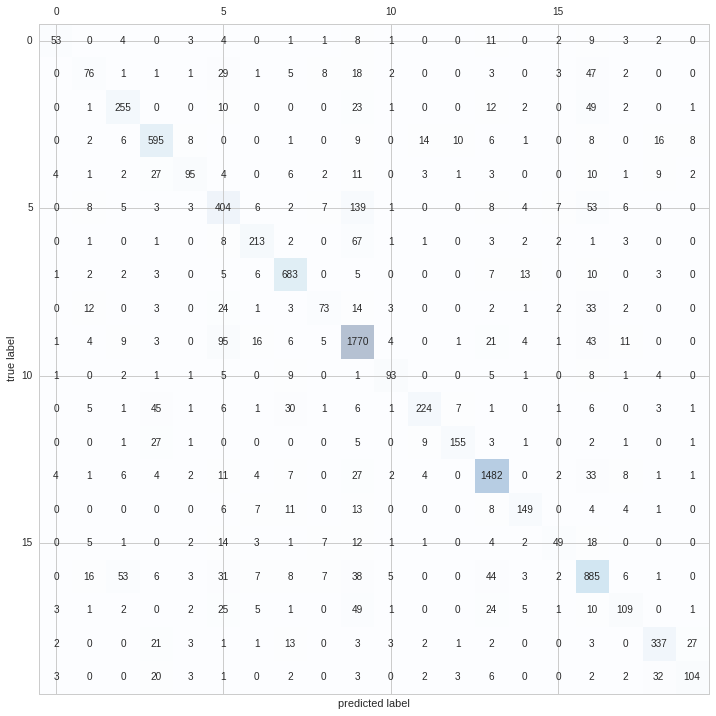

In [132]:
# replicating the best model
model = Pipeline([
            # using the best parameters
            ('tfidf', TfidfVectorizer(strip_accents='unicode', 
                                      analyzer='word', ngram_range=(1,3)
                                     )),
            # using linear svc
            ('clf', OneVsRestClassifier(LinearSVC(random_state=1)))
        ])
# and evaluate
train_and_evaluate(model, X_train, X_test, y_train, y_test)

## 5.2. Predicting 
And using this to predict against test.json data.

In [133]:
# read test.json
testdf = pd.read_json('../data/test.json')

In [134]:
# do the data prep for test.json data
testdf['ingredients_all'] = testdf.ingredients.apply(lambda x: " ".join(clean_ingredients(x)))

In [135]:
# predict it
X1_test = testdf['ingredients_all']
y1_pred = model.predict(X1_test)

In [136]:
idx = testdf.id.values.astype(int)

cuisine_inverse_mapping = {v: k for k, v in cuisine_mapping.items()}
cuisine_inverse_mapping

{0: u'brazilian',
 1: u'british',
 2: u'cajun_creole',
 3: u'chinese',
 4: u'filipino',
 5: u'french',
 6: u'greek',
 7: u'indian',
 8: u'irish',
 9: u'italian',
 10: u'jamaican',
 11: u'japanese',
 12: u'korean',
 13: u'mexican',
 14: u'moroccan',
 15: u'russian',
 16: u'southern_us',
 17: u'spanish',
 18: u'thai',
 19: u'vietnamese'}

In [137]:
y1_pred = [cuisine_inverse_mapping[w] for w in y1_pred]

In [138]:
# and generate the output
output_df = pd.DataFrame()
output_df['id'] = idx
output_df['cuisine'] = y1_pred
output_df.to_csv('output.csv',index=False)

# 6. Conclusion

In this paper, I outline the approach that I took to produce a solution for the [What's Cooking](https://www.kaggle.com/c/whats-cooking) Kaggle competition. 

The approach follows the iterative process of data exploration, data cleaning, feature engineering, modeling, and finally prediction.  

![Fig 3. Process](https://raw.githubusercontent.com/bluegrapes/DAT8Coursework/master/project2/code/images/modeling.png)

